<b>Project</b>: Population segmentation and transition probability estimation using data on health and health-related social service needs from the US Health and Retirement Study <br>
<b>Project section</b>: Population segmentation <br>
<b>Python version</b>: 3.9.7 <br>
<b>File name</b>: 04_Survival_Analysis.ipynb <br>
<b>Data required</b>: data_GI_CF.csv <br>
<b>Outcome</b>: Performs Kaplan Meier survival analysis and Cox Regression analysis on mortality on GI segments and CF status <br>
<b>Author</b>: Lize Duminy<br>
<b>Date</b>: 2024.12.15 

# Instructions for use

1. This script requires the dataset __data_GI_CF.csv__, generated by running __03_Complicating_Factors.ipynb__.
2. To execute this script, replace the filepath of the variable __global_path__ in the code below (currently _C:/Users/lize.duminy/data/HRS/data/_) with the filepath of your designated folder for raw data in section __1.1. USER INPUT REQUIRED: Replace this filepath with the filepath of your designated folder for raw data__ below. 

# 1. Praparation

#### Import packages

In [2]:
#! pip install lifelines

In [3]:
from lifelines import KaplanMeierFitter # for survival analysis
from lifelines.statistics import logrank_test # for Log-Rank test
from statsmodels.stats.multitest import multipletests # Adjust p-values for multiple comparisons using the Holm-Bonferroni method
from lifelines.statistics import multivariate_logrank_test #calculating the overall log-rank test
from lifelines import CoxPHFitter # for survival analysis
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import concordance_index
import pandas as pd # for dealing with dataframes
import numpy as np # for numerical calculations
import random
import os
import os.path
import matplotlib.pyplot as plt 

### 1.1. USER INPUT REQUIRED: Replace this filepath with the filepath of your designated folder for data

In [4]:
#Filepath for data
global_path=os.path.join("C:/Users/lize_/data/HRS/data/")
print(global_path)

#Filepath for Kaplan-Meier survival curves
km_path=os.path.join("C:/Users/lize_/data/HRS/02_results/01_KaplanMeier/")
#km_path=os.path.join("")
print(km_path)

#Filepath for Cox regression analysis on mortality
cr_path=os.path.join("C:/Users/lize_/data/HRS/02_results/02_CoxRegression/")
#cr_path=os.path.join("")
print(cr_path)

C:/Users/lize_/data/HRS/data/
C:/Users/lize_/data/HRS/02_results/01_KaplanMeier/
C:/Users/lize_/data/HRS/02_results/02_CoxRegression/


### 1.2. Load data

#### Load "data_GI_CF.csv"

In [5]:
filepath = os.path.join(global_path , "data_GI_CF.csv")
data = pd.read_csv(filepath, low_memory=False)
print(data.shape)

(61817, 166)


#### Load "data.csv"

In [6]:
filepath0 = os.path.join(global_path , "dataHRS.csv")
data0 = pd.read_csv(filepath0)
print(data0.shape)

(61817, 96)


# 2. Kaplan-Meier survival curves of mortality and Log-Rank test 

## 2.1. Prepare data

#### Reduce and sort data

In [7]:
#Remove unnecessary rows and columns 
data0 = data0.loc[(data0.wave>=8)&(data0.wave<=14),
                  ['hhidpn', 'alive', 'wave', 'iwmonth', 'iwyear', 
                   'knowndeceasedmo', 'knowndeceasedyr', 'birthmo', 'birthyr']]

# Sort data by ID and wave
data = data.sort_values(["hhidpn", "wave"])
data0 = data0.sort_values(["hhidpn", "wave"])


#### Drop respondents that were not allocated a GI segment in wave 8 

In [8]:
#Identify hhidpn numbers interviewed in wave 8
selected = data.loc[(data.wave==8)&(data.GI>=1),'hhidpn']

#Create variable that indicates whether specific hhidpn was 
#interviewed in wave 8 across all waves
selected = np.array(selected)
hhidpn = np.array(data0['hhidpn'])
selected = np.isin(hhidpn, selected)

#Reduce dataframe to contain only selected variables
data0 = data0[selected]

print("Number of respondents per wave:")
data0.wave.value_counts().sort_index()

Number of respondents per wave:


wave
8     7158
9      339
10    5646
11     390
12    4814
13     527
14    3358
Name: count, dtype: int64

### Identify necessary datapoints from initial interview

#### Create a dataframe with GI, CFs and initial interview dates

In [9]:
#Identify GI and CF state at first wave
data_init = data.loc[(data.wave==8)&(data.GI>=1),
                     ['hhidpn','GI','CF', 'fun_assess', 'nrs_rhab', 
                      'disrupt', 'freq_trans', 'polypharm', 'iwmonth', 
                      'iwyear', 'birthmo', 'birthyr', 'gender']]

#Rename variables
data_init.rename(columns = {'GI':'init_GI'}, inplace = True)
data_init.rename(columns = {'CF':'init_CF'}, inplace = True)

### Calculate t_init: time of initial interview (wave 8)

In [10]:
#calculate the initial interview time (t_init)
data_init['t_init'] = (data_init.iwmonth-1)/12 + data_init.iwyear

data_init['age'] = data_init.t_init - (data.birthyr + (data.birthmo-1)/12)

#Restrict data_init to the necessary columns
data_init = data_init[['hhidpn', 'init_GI','init_CF', 't_init', 'fun_assess', 
                       'nrs_rhab', 'disrupt', 'freq_trans', 'polypharm', 
                       'age', 'gender']]

#Number of entries with no initial interview date
print("Number of entries with no initial interview date (t_init):")
x = data_init.hhidpn.value_counts().sum() - data_init.t_init.value_counts().sum()
print(x)

Number of entries with no initial interview date (t_init):
0


### Identify necessary datapoints from final interview

#### Create a dataframe with the final wave of each hhidpn, including the time of last interview 

In [11]:
#Find the last available record of each hhidpn
data_fin = data0.groupby('hhidpn')[['wave']].last()
data_fin = data_fin.reset_index()

#rename wave to specify that it is the final wave individual participated in
data_fin.rename(columns = {'wave':'wave_fin'}, inplace = True)

#merge "wave_fin" to data0 
data_fin = pd.merge(data0, data_fin, how="left", on=["hhidpn"])

#Reduce rows to only include the entries related to the final entry per hhidpn
data_fin = data_fin.loc[(data_fin.wave == data_fin.wave_fin)]

#Rename "alive" to indicate whether individual is dead or alive in the 
#final wave or observation
data_fin.rename(columns = {'alive':'alive_fin'}, inplace = True)

data_fin = data_fin[['hhidpn', 'wave_fin', 'alive_fin', 'iwmonth', 'iwyear', 
                     'knowndeceasedmo', 'knowndeceasedyr']]

#### Calculate t_iw: time of last interview

In [12]:
data_fin['t_iw'] = (data_fin.iwmonth-1)/12 + data_fin.iwyear

#Number of entries with no "last interview" date
print("Number of entries with no last interview date (t_iw):")
x = data_fin.hhidpn.value_counts().sum() - data_fin.t_iw.value_counts().sum()
print(x)

Number of entries with no last interview date (t_iw):
308


### Identify necessary datapoints from last alive interview

#### Create a dataframe with the final alive wave of each hhidpn

In [13]:
#Find the last available record of hhidpn being alive
data_la = data0[data0.alive==1]
data_la = data_la.groupby('hhidpn')[['iwmonth', 'iwyear']].last()
data_la = data_la.reset_index()


data_la.rename(columns = {'iwmonth':'la_iwmonth'}, inplace = True)
data_la.rename(columns = {'iwyear':'la_iwyear'}, inplace = True)


#### Calculate t_la: time of last alive interview

In [14]:
data_la['t_la'] = (data_la.la_iwmonth-1)/12 + data_la.la_iwyear

#Number of entries with no "last alive interview" date
print("Number of entries with no last alive interview date (t_la):")
x = data_la.hhidpn.value_counts().sum() - data_la.t_la.value_counts().sum()
print(x)

Number of entries with no last alive interview date (t_la):
0


### Merge dataframes data_fin and data_la

In [15]:
#Merge data on final record and last alive record
data_fin = pd.merge(data_fin, data_la, how="left", on=["hhidpn"])

### Assign mean interview time per wave to entries with no final interview time (t_iw)

In [16]:
#Assign the mean interview date per wave to individuals with missing dates

#isolate variables of interest from data0
data_iw_m = data0[['wave', 'iwmonth', 'iwyear']]
data_iw_m = pd.DataFrame(data_iw_m)

#Calculate date of interview per entry
data_iw_m['t_iw'] = (data_iw_m.iwmonth-1)/12 + data_iw_m.iwyear

#Calculate the mean interview date per wave
data_iw_m = data_iw_m.groupby('wave')[['t_iw']].mean()
data_iw_m = data_iw_m.reset_index()

#rename variable
data_iw_m.rename(columns = {'t_iw':'t_iw_mean'}, inplace = True)
data_iw_m.rename(columns = {'wave':'wave_fin'}, inplace = True)

#Insert mean interview date per wave to data_fin
data_fin = pd.merge(data_fin, data_iw_m, how="left", on=["wave_fin"])
data_fin.loc[pd.isnull(data_fin.t_iw), 't_iw'] = data_fin.t_iw_mean

#Number of entries with no "last interview" date
print("Number of entries with no last interview date (t_iw):")
x = (data_fin.hhidpn.value_counts().sum() - 
     data_fin.t_iw.value_counts().sum())
print(x)


Number of entries with no last interview date (t_iw):
0


In [17]:
data_fin['t_d'] = (data_fin.knowndeceasedmo-1)/12 + data_fin.knowndeceasedyr

data_fin['test1'] = data_fin.knowndeceasedmo == 98
data_fin['test2'] = data_fin.knowndeceasedyr < data_fin.la_iwyear

data_fin['t_d_min'] = data_fin.t_la
data_fin.loc[(data_fin.t_la < data_fin.knowndeceasedyr), 
             't_d_min'] = data_fin.knowndeceasedyr
data_fin['t_d_max'] = 11/12+data_fin.knowndeceasedyr
data_fin.loc[(data_fin.knowndeceasedmo == 98), 
             't_d'] = random.uniform(data_fin.t_d_min, data_fin.t_d_max)

data_fin.loc[(data_fin.t_la < data_fin.knowndeceasedyr), 
             't_d'] = random.uniform(data_fin.t_la, data_fin.t_iw)


In [18]:
#are there individuals with a t_d who were never assigned alive==5?
print("Number of individuals with a death date (t_d), ",
      "with no exit interview (alive==5):")
print(len(data_fin[(data_fin.alive_fin != 5)&(data_fin.t_d > 0)]))

Number of individuals with a death date (t_d),  with no exit interview (alive==5):
943


In [19]:
#are there and deceased individuals without a t_d?
print("Number of individuals who are known to be deceased ",
      "without a death date (t_d):")
x = (data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d)
print(len(data_fin[x]))

Number of individuals who are known to be deceased  without a death date (t_d):
27


In [20]:
#Calculate an assumed death date as a random date between last live 
#interview and the date of exit interview
data_fin.loc[(data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d), 
             't_d'] = random.uniform(data_fin.t_la, data_fin.t_iw)

#are there and deceased individuals without a t_d?
print("Number of individuals who are known to be deceased without ",
      "a death date (t_d):")
x = (data_fin.alive_fin == 5)&pd.isnull(data_fin.t_d)
print(len(data_fin[x]))

Number of individuals who are known to be deceased without  a death date (t_d):
0


In [21]:
#Create variable showing the date of contact: t_fin

#Assign all entries the most recent interview date
data_fin['t_fin'] = data_fin.t_iw

#For those entries who are deceased, change the date to the death date
data_fin.loc[data_fin.t_d > 0, 't_fin'] = data_fin.t_d

#determine if dead or alive
data_fin['event'] = np.nan
data_fin.loc[data_fin.alive_fin == 1, 'event'] = 0 ###alive
data_fin.loc[data_fin.alive_fin == 5, 'event'] = 1 ###deceased

data_fin.wave_fin.value_counts()

wave_fin
14    3358
12    1390
10     815
13     527
11     390
8      339
9      339
Name: count, dtype: int64

In [22]:
#Merge data regarding the initial and final observation in a single row
data = pd.merge(data_init, data_fin, how="left", on=["hhidpn"])

data['time'] = data.t_fin - data.t_init

data.loc[data.time < 0, 'time'] = data.t_iw - data.t_init

data = data[['hhidpn', 'init_GI', 'init_CF', 'fun_assess', 'nrs_rhab', 'disrupt', 
             'freq_trans', 'polypharm', 'event', 'time', 'age', 'gender']]

In [23]:
print("Number of individuals experiencing event compared to those who do not:")
print(data.event.value_counts().sort_index())

Number of individuals experiencing event compared to those who do not:
event
0.0    4558
1.0    2600
Name: count, dtype: int64


In [24]:
print(data.init_GI.value_counts().sort_index())

init_GI
1.0     816
2.0    1387
3.0    3114
4.0     613
5.0    1228
Name: count, dtype: int64


## 2.2. Model fitting

### GI segments

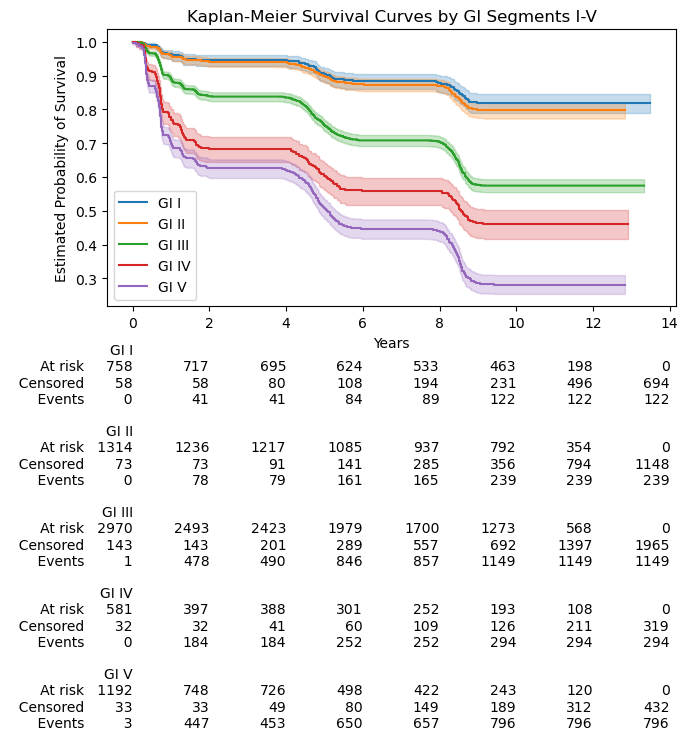

In [25]:
# Define GI segments
GI_I = data.init_GI == 1  # GI == 1 at wave 8
GI_II = data.init_GI == 2  # GI == 2 at wave 8
GI_III = data.init_GI == 3  # GI == 3 at wave 8
GI_IV = data.init_GI == 4  # GI == 4 at wave 8
GI_V = data.init_GI == 5  # GI == 5 at wave 8

# Create a figure with specified size
fig, a1 = plt.subplots(figsize=(7, 8))  

# Fit the model for GI I
kmf_I = KaplanMeierFitter()
a1 = kmf_I.fit(data.time[GI_I], data.event[GI_I], label='GI I').plot_survival_function(ax=a1)

# Fit the model for GI II
kmf_II = KaplanMeierFitter()
a1 = kmf_II.fit(data.time[GI_II], data.event[GI_II], label='GI II').plot_survival_function(ax=a1)

# Fit the model for GI III
kmf_III = KaplanMeierFitter()
a1 = kmf_III.fit(data.time[GI_III], data.event[GI_III], label='GI III').plot_survival_function(ax=a1)

# Fit the model for GI IV
kmf_IV = KaplanMeierFitter()
a1 = kmf_IV.fit(data.time[GI_IV], data.event[GI_IV], label='GI IV').plot_survival_function(ax=a1)

# Fit the model for GI V
kmf_V = KaplanMeierFitter()
a1 = kmf_V.fit(data.time[GI_V], data.event[GI_V], label='GI V').plot_survival_function(ax=a1)

# Add plot details
a1.set_title("Kaplan-Meier Survival Curves by GI Segments I-V")
a1.set_ylabel("Estimated Probability of Survival")
a1.set_xlabel("Years")

# Add risk table
add_at_risk_counts(kmf_I, kmf_II, kmf_III, kmf_IV, kmf_V, ax=a1)
plt.tight_layout()

# Save the plot
kmf1_filepath = os.path.join(km_path, "KM_GI.png")
plt.savefig(kmf1_filepath)

# Show the plot
plt.show()

In [26]:
print(km_path)

C:/Users/lize_/data/HRS/02_results/01_KaplanMeier/


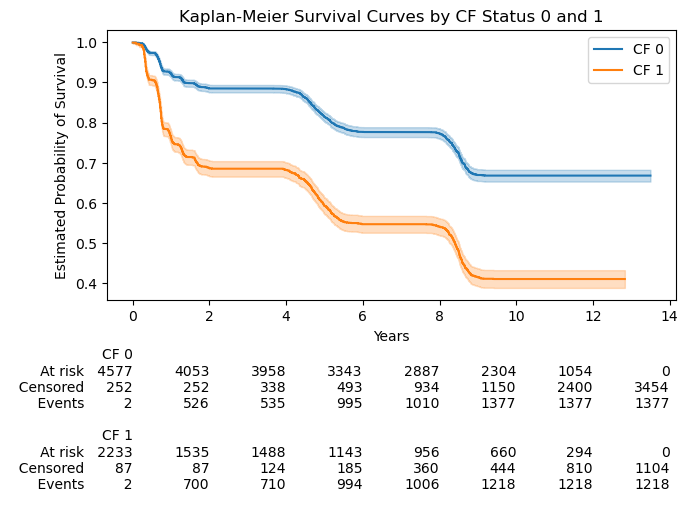

In [27]:
# Define CF segments
CF_0 = data.init_CF == 0  # CF == 0 at wave 8
CF_1 = data.init_CF == 1  # CF == 1 at wave 8

# Create a figure with specified size
fig, a1 = plt.subplots(figsize=(7, 5.5))  

# Fit the model for CF 0
kmf_0 = KaplanMeierFitter()
a1 = kmf_0.fit(data.time[CF_0], data.event[CF_0], label='CF 0').plot_survival_function(ax=a1)

# Fit the model for CF 1
kmf_1 = KaplanMeierFitter()
a1 = kmf_1.fit(data.time[CF_1], data.event[CF_1], label='CF 1').plot_survival_function(ax=a1)

# Add plot details
a1.set_title("Kaplan-Meier Survival Curves by CF Status 0 and 1")
a1.set_ylabel("Estimated Probability of Survival")
a1.set_xlabel("Years")

# Add risk table
add_at_risk_counts(kmf_0, kmf_1, ax=a1)
plt.tight_layout()

# Save the plot
kmf1_filepath = os.path.join(km_path, "KM_CF.png")
plt.savefig(kmf1_filepath)

# Show the plot
plt.show()

# 3. Log-rank test

## Pairwise log-rank tests

In [28]:

# List of unique groups (GI segments)
groups = sorted(data['init_GI'].unique())

# Initialize matrices for test statistics and p-values
n = len(groups)
test_stat_matrix = np.full((n, n), np.nan)
p_value_matrix = np.full((n, n), np.nan)

# Perform pairwise log-rank tests and populate matrices
for i in range(n):
    for j in range(i + 1, n):
        group1 = groups[i]
        group2 = groups[j]

        # Subset data for the two groups
        data_group1 = data[data['init_GI'] == group1]
        data_group2 = data[data['init_GI'] == group2]

        # Perform log-rank test
        result = logrank_test(
            data_group1['time'], data_group2['time'],
            data_group1['event'], data_group2['event']
        )
        # Fill in the matrices
        test_stat_matrix[i, j] = result.test_statistic
        p_value_matrix[i, j] = result.p_value

# Adjust p-values for multiple comparisons using the Holm-Bonferroni method
flat_p_values = p_value_matrix[~np.isnan(p_value_matrix)]
adjusted_p_values = multipletests(flat_p_values, method='holm')[1]

# Refill the matrix with adjusted p-values
p_value_matrix[~np.isnan(p_value_matrix)] = adjusted_p_values

# Format p-values for display
def format_p_value(p):
    if p < 0.001:
        return "<0.001"
    elif p < 0.01:
        return f"{p:.3f}"
    elif p < 0.20:
        return f"{p:.3f}"
    else:
        return f"{p:.2f}"

# Format the test statistic according to MDM requirements
def format_statistic(value):
    if value < 1:
        return f"{value:.3f}"
    else:
        return f"{value:.2f}"

# Apply formatting to the test statistic and p-value matrices
formatted_test_stat_matrix = np.full((n, n), "", dtype=object)
formatted_p_value_matrix = np.full((n, n), "", dtype=object)

for i in range(n):
    for j in range(n):
        if not np.isnan(test_stat_matrix[i, j]):
            formatted_test_stat_matrix[i, j] = format_statistic(test_stat_matrix[i, j])
        if not np.isnan(p_value_matrix[i, j]):
            formatted_p_value_matrix[i, j] = format_p_value(p_value_matrix[i, j])

# Convert matrices to DataFrames for better readability
formatted_test_stat_df = pd.DataFrame(formatted_test_stat_matrix, index=groups, columns=groups)
formatted_p_value_df = pd.DataFrame(formatted_p_value_matrix, index=groups, columns=groups)

# Display results
print("Log-Rank Test Statistics (Formatted, Upper Triangle):")
print(formatted_test_stat_df)
print("\nAdjusted P-Values (Formatted, Upper Triangle):")
print(formatted_p_value_df)

Log-Rank Test Statistics (Formatted, Upper Triangle):
    1.0   2.0     3.0     4.0     5.0
1.0      1.20  127.67  210.92  484.13
2.0            174.44  268.07  710.12
3.0                     47.82  373.37
4.0                             36.11
5.0                                  

Adjusted P-Values (Formatted, Upper Triangle):
    1.0   2.0     3.0     4.0     5.0
1.0      0.27  <0.001  <0.001  <0.001
2.0            <0.001  <0.001  <0.001
3.0                    <0.001  <0.001
4.0                            <0.001
5.0                                  


In [29]:
# Define CF segments
CF_0 = data.init_CF == 0
CF_1 = data.init_CF == 1

# Perform log-rank test
results_CF1_CF0 = logrank_test(data.time[CF_0], data.time[CF_1], event_observed_A=data.event[CF_0], event_observed_B=data.event[CF_1])

# Format the test statistic according to MDM requirements
def format_statistic(value):
    if value < 1:
        return f"{value:.3f}"
    else:
        return f"{value:.2f}"

# Apply p-value reporting requirements
def format_p_value(p):
    if p < 0.001:
        return "<0.001"
    elif p < 0.01:
        return f"{p:.3f}"
    elif p < 0.20:
        return f"{p:.3f}"
    else:
        return f"{p:.2f}"

# Print the formatted results
print("Log-Rank Test Statistic:")
print(format_statistic(results_CF1_CF0.test_statistic))

print("Log-Rank p-value:")
print(format_p_value(results_CF1_CF0.p_value))

Log-Rank Test Statistic:
491.93
Log-Rank p-value:
<0.001


## Overall log-rank tests

In [30]:
#Create HASS need state variable
#GI I
data["init_HS"] = 0
data.loc[(data.init_GI==1)&(data.init_CF==0),'init_HS'] = 1
data.loc[(data.init_GI==1)&(data.init_CF==1),'init_HS'] = 2

#GI II
data.loc[(data.init_GI==2)&(data.init_CF==0),'init_HS'] = 3
data.loc[(data.init_GI==2)&(data.init_CF==1),'init_HS'] = 4

#GI III
data.loc[(data.init_GI==3)&(data.init_CF==0),'init_HS'] = 5
data.loc[(data.init_GI==3)&(data.init_CF==1),'init_HS'] = 6

#GI IV
data.loc[(data.init_GI==4)&(data.init_CF==0),'init_HS'] = 7
data.loc[(data.init_GI==4)&(data.init_CF==1),'init_HS'] = 8

#GI V
data.loc[(data.init_GI==5)&(data.init_CF==0),'init_HS'] = 9
data.loc[(data.init_GI==5)&(data.init_CF==1),'init_HS'] = 10


In [31]:
#Calculating the overall log-rank p-value for HS

# Perform the overall log-rank test
results = multivariate_logrank_test(
    data['time'],
    data['init_HS'],
    data['event']
)

# Extract the test statistic and p-value
overall_test_statistic = results.test_statistic
overall_p_value = results.p_value

# Print the results
print(f"Overall Log-Rank Test Statistic: {overall_test_statistic:.2f}")
if overall_p_value < 0.001:
    print("Overall Log-Rank P-Value: <0.001")
else:
    print(f"Overall Log-Rank P-Value: {overall_p_value:.3f}")

Overall Log-Rank Test Statistic: 1205.62
Overall Log-Rank P-Value: <0.001


In [32]:
#Calculating the overall log-rank p-value for GI

# Perform the overall log-rank test
results = multivariate_logrank_test(
    data['time'],
    data['init_GI'],
    data['event']
)

# Extract the test statistic and p-value
overall_test_statistic = results.test_statistic
overall_p_value = results.p_value

# Print the results
print(f"Overall Log-Rank Test Statistic: {overall_test_statistic:.2f}")
if overall_p_value < 0.001:
    print("Overall Log-Rank P-Value: <0.001")
else:
    print(f"Overall Log-Rank P-Value: {overall_p_value:.3f}")

Overall Log-Rank Test Statistic: 1025.71
Overall Log-Rank P-Value: <0.001


In [33]:
#Calculating the overall log-rank p-value for CF

# Perform the overall log-rank test
results = multivariate_logrank_test(
    data['time'],
    data['init_CF'],
    data['event']
)

# Extract the test statistic and p-value
overall_test_statistic = results.test_statistic
overall_p_value = results.p_value

# Print the results
print(f"Overall Log-Rank Test Statistic: {overall_test_statistic:.2f}")
if overall_p_value < 0.001:
    print("Overall Log-Rank P-Value: <0.001")
else:
    print(f"Overall Log-Rank P-Value: {overall_p_value:.3f}")

Overall Log-Rank Test Statistic: 502.02
Overall Log-Rank P-Value: <0.001


# 3. Cox proportional hazard models of mortality

## 3.1. Prepare data

In [41]:
#define data for cox regression
data_cox = pd.DataFrame(data) 

#remove entries without an age
data_cox.dropna(subset=["age"], inplace=True)
print(data_cox.age.isna().value_counts())


data_cox.loc[(data_cox.gender=="1.male"),'gender'] = 0
data_cox.loc[(data_cox.gender=="2.female"),'gender'] = 1
data_cox.rename(columns = {'gender':'female'}, inplace = True)

#Create dummy variables for CF 1
data_cox["init_CF_1"] = 0
data_cox.loc[(data_cox.init_CF==1),'init_CF_1'] = 1

#Create HASS need state variable
#GI I
data_cox["init_HS"] = 0
data_cox.loc[(data_cox.init_GI==1)&(data_cox.init_CF==0),'init_HS'] = 1
data_cox.loc[(data_cox.init_GI==1)&(data_cox.init_CF==1),'init_HS'] = 2

#GI II
data_cox.loc[(data_cox.init_GI==2)&(data_cox.init_CF==0),'init_HS'] = 3
data_cox.loc[(data_cox.init_GI==2)&(data_cox.init_CF==1),'init_HS'] = 4

#GI III
data_cox.loc[(data_cox.init_GI==3)&(data_cox.init_CF==0),'init_HS'] = 5
data_cox.loc[(data_cox.init_GI==3)&(data_cox.init_CF==1),'init_HS'] = 6

#GI IV
data_cox.loc[(data_cox.init_GI==4)&(data_cox.init_CF==0),'init_HS'] = 7
data_cox.loc[(data_cox.init_GI==4)&(data_cox.init_CF==1),'init_HS'] = 8

#GI V
data_cox.loc[(data_cox.init_GI==5)&(data_cox.init_CF==0),'init_HS'] = 9
data_cox.loc[(data_cox.init_GI==5)&(data_cox.init_CF==1),'init_HS'] = 10


age
False    7158
Name: count, dtype: int64


### 3.2. Model fitting 

In [40]:
# Calculate the concordance index for each predictor individually
predictors = ['init_GI', 'init_CF_1', 'age', 'female', 'init_HS']
c_indices = {}

for predictor in predictors:
    temp_df = data_cox[[predictor, 'time', 'event']]
    cph_temp = CoxPHFitter()
    cph_temp.fit(temp_df, duration_col='time', event_col='event')
    c_index = concordance_index(temp_df['time'], -cph_temp.predict_partial_hazard(temp_df), temp_df['event'])
    c_indices[predictor] = c_index

# Print the c-indices for each predictor
for predictor, c_index in c_indices.items():
    print(f"Concordance Index for {predictor}: {c_index}")

# Rank predictors by c-index
ranked_predictors = sorted(c_indices, key=c_indices.get, reverse=True)
print("\nPredictors ranked by predictive ability (c-index):")
for i, predictor in enumerate(ranked_predictors, 1):
    print(f"{i}. {predictor} (c-index: {c_indices[predictor]:.3f})")

Concordance Index for init_GI: 0.6665277953544559
Concordance Index for init_CF_1: 0.6039164696523253
Concordance Index for age: 0.7354768419021039
Concordance Index for female: 0.5321865250776578
Concordance Index for init_HS: 0.6777248548664129

Predictors ranked by predictive ability (c-index):
1. age (c-index: 0.735)
2. init_HS (c-index: 0.678)
3. init_GI (c-index: 0.667)
4. init_CF_1 (c-index: 0.604)
5. female (c-index: 0.532)
